In [1]:
import sys
from pathlib import Path


root_dir = Path().absolute()
# Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
root_dir = str(root_dir) 
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/emaminotti/ID2223-ScalableMLDL_Project
HopsworksSettings initialized!


### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
import shutil
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import util
import json
import joblib

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [3]:
import hopsworks

# Login e connessione ai servizi Hopsworks
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

# Configurazione per Stoccolma
# Inseriamo le coordinate usate per il backfill
city = "Stockholm"
country = "Sweden"
latitude = 59.3293
longitude = 18.0686


print(f"✅ Configurazione caricata per: {city} (Lat: {latitude}, Lon: {longitude})")

2025-12-20 18:47:32,815 INFO: Initializing external client
2025-12-20 18:47:32,816 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-12-20 18:47:34,258 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267872
✅ Configurazione caricata per: Stockholm (Lat: 59.3293, Lon: 18.0686)


In [4]:
try:
    pollen_fg = fs.get_feature_group(name="pollen_measurements", version=1)
    weather_fg = fs.get_feature_group(name="weather_measurements", version=1)
    
    print("✅ Feature Groups recuperati con successo:")
    print(f"   - {pollen_fg.name} (v{pollen_fg.version})")
    print(f"   - {weather_fg.name} (v{weather_fg.version})")

except Exception as e:
    print(f"❌ Errore nel recupero dei Feature Group: {e}")
    print("Assicurati di aver eseguito il notebook di backfill.")

✅ Feature Groups recuperati con successo:
   - pollen_measurements (v1)
   - weather_measurements (v1)


## <span style="color:#ff5f27;"> Feature View Creation and Retrieving </span>

In [5]:
# 1. Definizione della Query di Join
# Selezioniamo tutte le feature dai pollini e le uniamo al meteo.
# Hopsworks userà automaticamente la Primary Key comune ('city', 'unix_time') per unire i dati.
query = pollen_fg.select_all().join(weather_fg.select_all())

# 2. Definizione dei Target
# Queste sono le variabili che il modello dovrà imparare a predire
targets = ["alder_pollen", "birch_pollen", "grass_pollen", "mugwort_pollen"]

# 3. Creazione (o recupero) della Feature View
try:
    feature_view = fs.get_or_create_feature_view(
        name="pollen_stockholm_fv",
        version=1,
        description="Feature view for forecasting pollen levels in Stockholm joining air quality and weather data.",
        labels=targets,          # Specifichiamo le colonne target
        query=query              # La logica di join
    )
    
    print("✅ Feature View 'pollen_stockholm_fv' creata o recuperata con successo.")
    print(f"   Targets: {feature_view.labels}")
    print(f"   Query: {feature_view.query.to_string()}")

except Exception as e:
    print(f"❌ Errore nella creazione della Feature View: {e}")

✅ Feature View 'pollen_stockholm_fv' creata o recuperata con successo.
   Targets: ['alder_pollen', 'birch_pollen', 'grass_pollen', 'mugwort_pollen']
   Query: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg1`.`date` `date`, `fg1`.`alder_pollen` `alder_pollen`, `fg1`.`birch_pollen` `birch_pollen`, `fg1`.`grass_pollen` `grass_pollen`, `fg1`.`mugwort_pollen` `mugwort_pollen`, `fg1`.`alder_pollen_lag_1` `alder_pollen_lag_1`, `fg1`.`alder_pollen_lag_2` `alder_pollen_lag_2`, `fg1`.`alder_pollen_lag_3` `alder_pollen_lag_3`, `fg1`.`birch_pollen_lag_1` `birch_pollen_lag_1`, `fg1`.`birch_pollen_lag_2` `birch_pollen_lag_2`, `fg1`.`birch_pollen_lag_3` `birch_pollen_lag_3`, `fg1`.`grass_pollen_lag_1` `grass_pollen_lag_1`, `fg1`.`grass_pollen_lag_2` `grass_pollen_lag_2`, `fg1`.`grass_pollen_lag_3` `grass_pollen_lag_3`, `fg1`.`mugwort_pollen_lag_1` `mugwort_pollen_lag_1`, `fg1`.`mugwort_pollen_lag_2` `mugwort_pollen_lag_2`, `fg1`.`mugwort_pollen_lag_3` `mugwort_pollen_lag_3`, `fg1`.`date_str` `date_str

## <span style="color:#ff5f27;">Split the training data into train/test data sets </span>

In [ ]:
# 1. Creazione del Training Dataset (Split temporale)
# Hopsworks salverà questa versione del dataset per riproducibilità.
# Usiamo test_size=0.2 per usare l'ultimo 20% dei dati come test.
version, job = feature_view.create_train_test_split(
    test_size=0.2,
    description='Time-series split (80% Train / 20% Test)',
    data_format='csv',
    write_options={'wait_for_job': True} # Attende che Hopsworks finisca di creare i file
)

print(f"✅ Training Dataset versione {version} creato con successo.")

# 2. Recupero dei DataFrame (X e y)
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(version)

# 3. Ordinamento temporale (Cruciale per Time Series)
# Assicuriamoci che i dati siano ordinati per data per evitare errori nel plotting o training
# Ordinamento temporale coerente con schema daily
X_train = X_train.sort_values("date")
X_test = X_test.sort_values("date")

# Allineiamo le y (target) agli indici ordinati di X
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

# 4. Verifica delle dimensioni
print(f"Train Set: {X_train.shape[0]} righe")
print(f"Test Set:  {X_test.shape[0]} righe")

# Mostra il periodo temporale coperto
train_start = pd.to_datetime(X_train["date"]).min().date()
train_end   = pd.to_datetime(X_train["date"]).max().date()
test_start  = pd.to_datetime(X_test["date"]).min().date()
test_end    = pd.to_datetime(X_test["date"]).max().date()


print(f"\n📅 Periodo Training: {train_start} -> {train_end}")
print(f"📅 Periodo Testing:  {test_start} -> {test_end}")

display(X_train.head(3))

## <span style="color:#ff5f27;">Modeling</span>

In [7]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# =========================================================
# 1. Configurazione del Modello XGBoost
# =========================================================
xgb_estimator = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

model = MultiOutputRegressor(xgb_estimator)

print("🚀 Avvio del training del modello Multi-Output XGBoost...")

# =========================================================
# 2. Selezione Feature
# =========================================================
features_to_drop = ["city", "country", "date", "date_str", "time", "unix_time"]
train_cols = [c for c in X_train.columns if c not in features_to_drop]

print(f"Features utilizzate ({len(train_cols)}): {train_cols}")

# =========================================================
# 3. FIX DTYPE (CRUCIALE per XGBoost)
# =========================================================
# Copia dei dataset
Xtr = X_train[train_cols].copy()
Xte = X_test[train_cols].copy()

# Converte tutto in numerico (object/string -> NaN)
Xtr = Xtr.apply(pd.to_numeric, errors="coerce")
Xte = Xte.apply(pd.to_numeric, errors="coerce")

# Riempie NaN e forza float32
Xtr = Xtr.fillna(0.0).astype("float32")
Xte = Xte.fillna(0.0).astype("float32")

# Anche il target (safe)
ytr = y_train.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype("float32")
yte = y_test.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype("float32")

# =========================================================
# 4. Training
# =========================================================
model.fit(Xtr, ytr)

print("✅ Training completato.")

# =========================================================
# 5. Valutazione sul Test Set
# =========================================================
y_pred = model.predict(Xte)

print("\n📊 Valutazione del Modello (R² e RMSE):")
r2_scores = []

for i, target_col in enumerate(yte.columns):
    r2 = r2_score(yte[target_col], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(yte[target_col], y_pred[:, i]))
    r2_scores.append(r2)

    print(f"   🔹 {target_col}: R² = {r2:.3f} | RMSE = {rmse:.2f}")

print(f"\n⭐ Media R² Score: {np.mean(r2_scores):.3f}")


🚀 Avvio del training del modello Multi-Output XGBoost...
Features utilizzate (22): ['alder_pollen_lag_1', 'alder_pollen_lag_2', 'alder_pollen_lag_3', 'birch_pollen_lag_1', 'birch_pollen_lag_2', 'birch_pollen_lag_3', 'grass_pollen_lag_1', 'grass_pollen_lag_2', 'grass_pollen_lag_3', 'mugwort_pollen_lag_1', 'mugwort_pollen_lag_2', 'mugwort_pollen_lag_3', 'weather_measurements_date', 'weather_measurements_temperature_2m_max', 'weather_measurements_temperature_2m_min', 'weather_measurements_temperature_2m_mean', 'weather_measurements_precipitation_sum', 'weather_measurements_rain_sum', 'weather_measurements_snowfall_sum', 'weather_measurements_wind_speed_10m_max', 'weather_measurements_wind_direction_10m_dominant', 'weather_measurements_weather_code']
✅ Training completato.

📊 Valutazione del Modello (R² e RMSE):
   🔹 alder_pollen: R² = 0.662 | RMSE = 0.35
   🔹 birch_pollen: R² = 0.846 | RMSE = 14.45
   🔹 grass_pollen: R² = 0.942 | RMSE = 0.56
   🔹 mugwort_pollen: R² = 0.871 | RMSE = 0.39



📅 Visualizzazione dati dal 2020-12-20 al 2025-12-20

📊 REPORT DI VALUTAZIONE
------------------------------------------------------------
🔹 ALDER_POLLEN -> MAE: 0.07 | R2: 0.659
🔹 BIRCH_POLLEN -> MAE: 4.34 | R2: 0.840
🔹 GRASS_POLLEN -> MAE: 0.21 | R2: 0.937
🔹 MUGWORT_POLLEN -> MAE: 0.10 | R2: 0.865


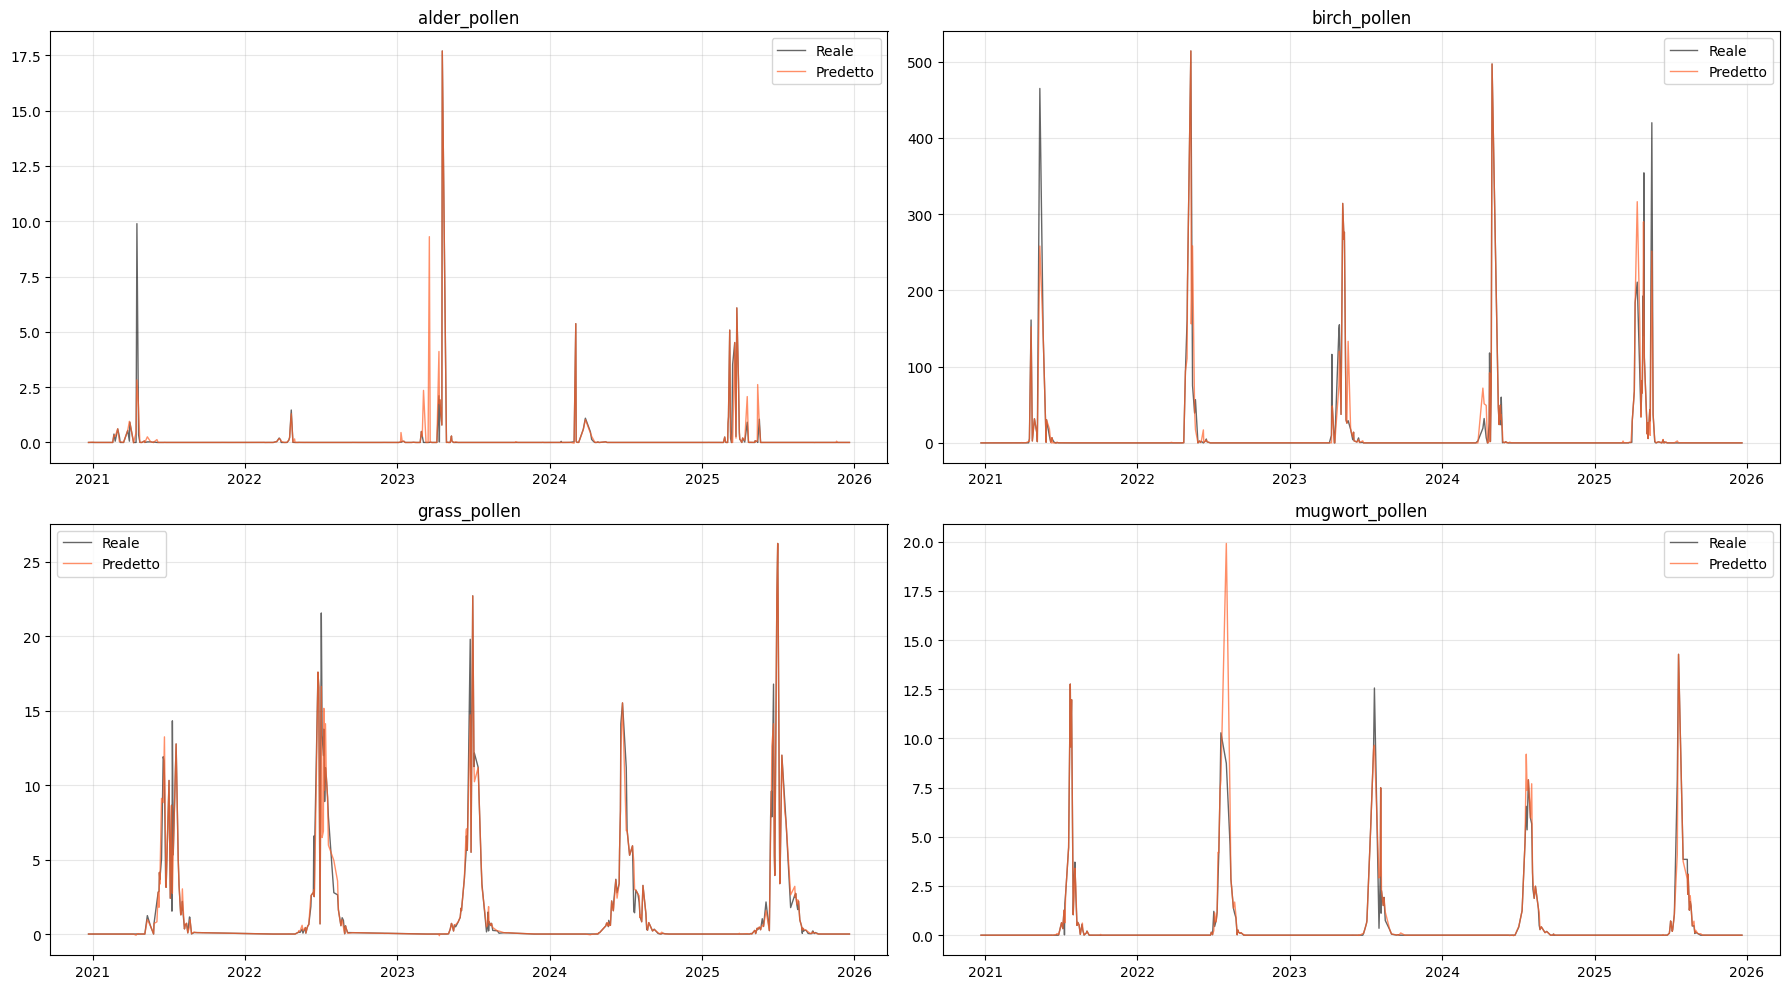


🔍 ZOOM SUL PICCO MASSIMO REALE


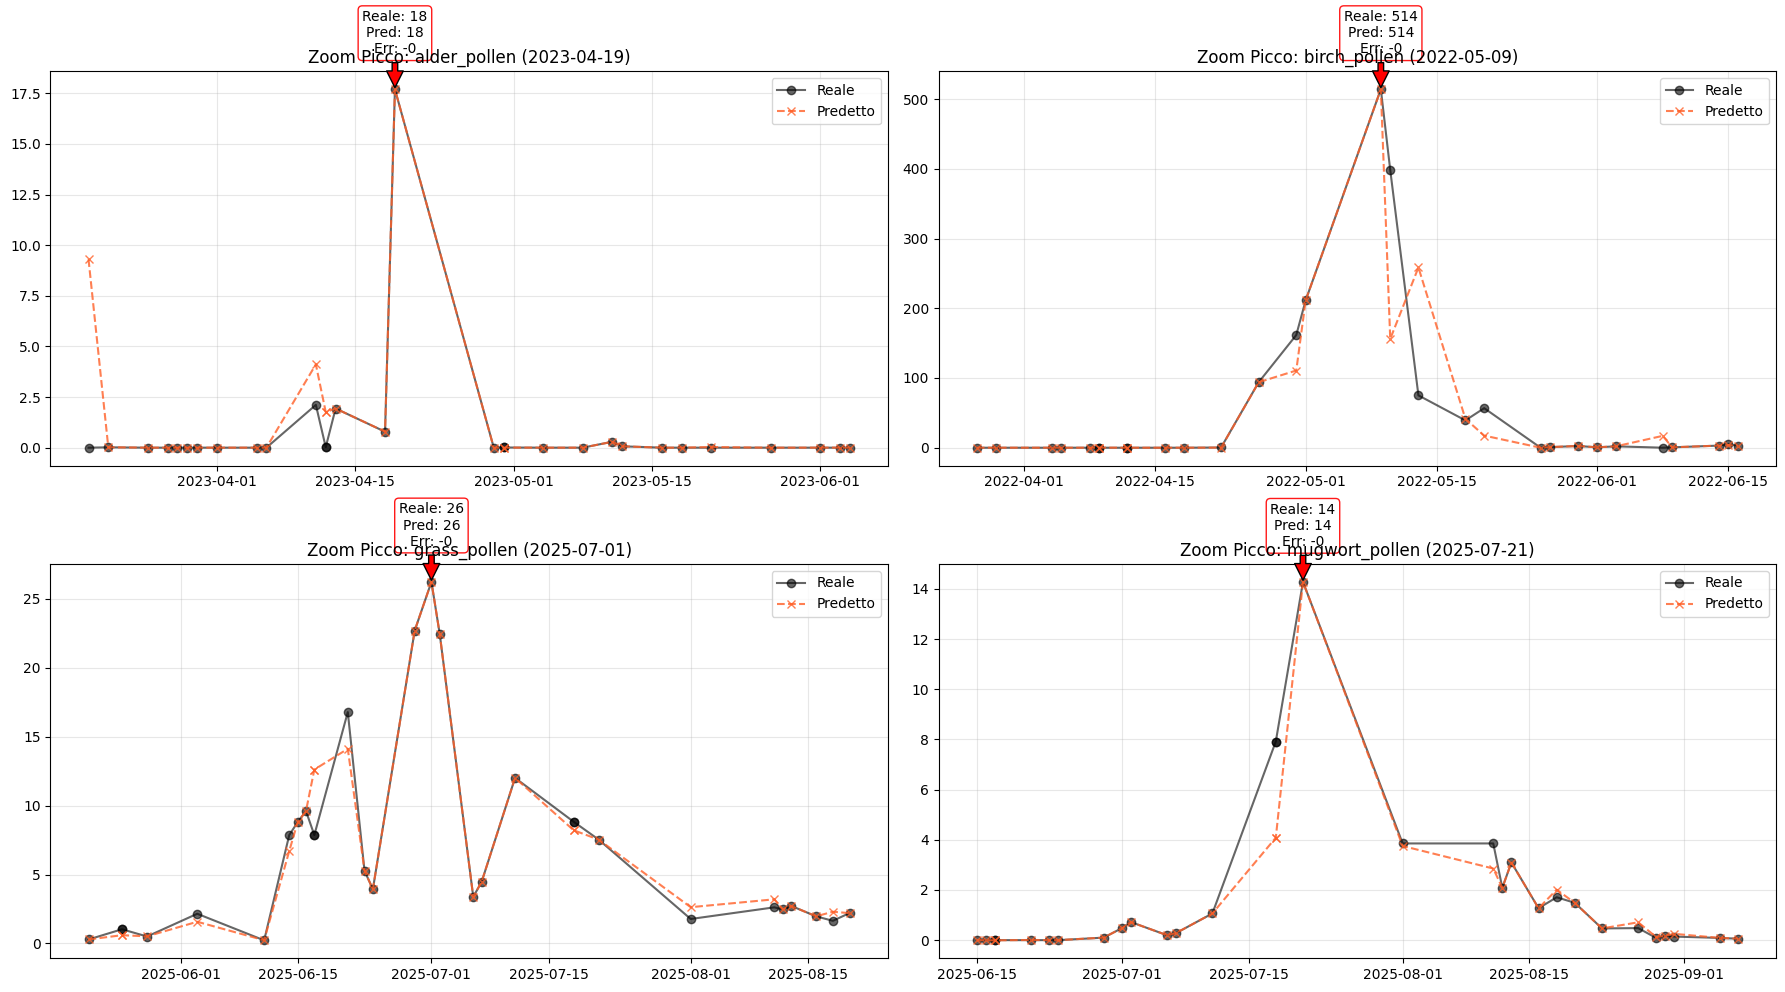

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================================================================
# 1. CREAZIONE DATAFRAME UNIFICATO (Per evitare disallineamenti)
# ==============================================================================
# Creiamo una copia per non modificare l'originale
df_viz = X_test.copy()

# Cerchiamo la colonna data
date_col = None
if "date" in df_viz.columns:
    date_col = "date"
elif "date_str" in df_viz.columns:
    date_col = "date_str"
elif "unix_time" in df_viz.columns:
    # Convertiamo unix in datetime direttamente
    df_viz["date_converted"] = pd.to_datetime(df_viz["unix_time"], unit="ms")
    date_col = "date_converted"

# Se non troviamo la data, creiamo un indice progressivo
if date_col is None:
    print("⚠️ Nessuna colonna data trovata. Uso indice progressivo.")
    df_viz["date_index"] = range(len(df_viz))
    date_col = "date_index"
else:
    # Assicuriamoci che sia datetime
    df_viz[date_col] = pd.to_datetime(df_viz[date_col])

# Aggiungiamo i Target Reali (y_test) al DataFrame
# Usiamo .copy() per sicurezza e manteniamo l'indice di X_test
for col in y_test.columns:
    df_viz[f"TRUE_{col}"] = y_test[col]

# Aggiungiamo le Predizioni (y_pred) al DataFrame
# y_pred è un array numpy, quindi dobbiamo assegnarlo rispettando l'ordine posizionale corrente
# IMPORTANTE: Assegnamo i valori direttamente all'array sottostante per evitare mismatch di indici
for i, col in enumerate(y_test.columns):
    df_viz[f"PRED_{col}"] = y_pred[:, i]

# ==============================================================================
# 2. ORDINAMENTO E FILTRO (Ultimi 5 Anni)
# ==============================================================================

# Ora possiamo ordinare il DataFrame unificato per data senza rompere i legami riga-per-riga
df_viz = df_viz.sort_values(by=date_col)

# Logica filtro temporale
if pd.api.types.is_datetime64_any_dtype(df_viz[date_col]):
    max_date = df_viz[date_col].max()
    cutoff_date = max_date - pd.DateOffset(years=5)
    
    # Filtriamo
    df_filtered = df_viz[df_viz[date_col] >= cutoff_date].copy()
    print(f"📅 Visualizzazione dati dal {cutoff_date.date()} al {max_date.date()}")
else:
    # Fallback se non è una data reale
    df_filtered = df_viz.iloc[-2000:].copy() # Ultimi 2000 punti
    print("⚠️ Date non datetime, mostro gli ultimi N punti disponibili.")

# ==============================================================================
# 3. PLOT PANORAMICA (Ultimi 5 Anni)
# ==============================================================================
targets = y_test.columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axs = axs.flatten()

print("\n📊 REPORT DI VALUTAZIONE")
print("-" * 60)

# Usiamo df_filtered per tutto d'ora in poi
dates_plot = df_filtered[date_col]

for i, col in enumerate(targets):
    y_true_col = df_filtered[f"TRUE_{col}"]
    y_pred_col = df_filtered[f"PRED_{col}"]
    
    # Metriche
    mae = mean_absolute_error(y_true_col, y_pred_col)
    r2 = r2_score(y_true_col, y_pred_col)
    
    print(f"🔹 {col.upper()} -> MAE: {mae:.2f} | R2: {r2:.3f}")
    
    # Plot
    ax = axs[i]
    ax.plot(dates_plot, y_true_col, label='Reale', color='black', alpha=0.6, linewidth=1)
    ax.plot(dates_plot, y_pred_col, label='Predetto', color='#ff5f27', alpha=0.7, linewidth=1)
    
    ax.set_title(f"{col}")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. FOCUS SUL PICCO (Zoom)
# ==============================================================================
print("\n🔍 ZOOM SUL PICCO MASSIMO REALE")

fig_peak, axs_peak = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axs_peak = axs_peak.flatten()

for i, col in enumerate(targets):
    # Dati filtrati
    y_true_col = df_filtered[f"TRUE_{col}"]
    y_pred_col = df_filtered[f"PRED_{col}"]
    
    # Troviamo l'indice del valore massimo REALE nel dataframe filtrato
    idx_max_val = y_true_col.idxmax()
    
    # Otteniamo la posizione intera di questo indice nel dataframe corrente
    # Questo serve per fare lo slicing +/- 15 giorni
    pos_max = df_filtered.index.get_loc(idx_max_val)
    
    # Definiamo finestra zoom (indici posizionali)
    start_pos = max(0, pos_max - 15)
    end_pos = min(len(df_filtered), pos_max + 15)
    
    # Estraiamo lo slice
    df_zoom = df_filtered.iloc[start_pos:end_pos]
    
    # Dati puntuali del picco
    peak_date = df_filtered.loc[idx_max_val, date_col]
    peak_true = df_filtered.loc[idx_max_val, f"TRUE_{col}"]
    peak_pred = df_filtered.loc[idx_max_val, f"PRED_{col}"]
    error = peak_pred - peak_true
    
    # Plot Zoom
    ax = axs_peak[i]
    ax.plot(df_zoom[date_col], df_zoom[f"TRUE_{col}"], 'o-', label='Reale', color='black', alpha=0.6)
    ax.plot(df_zoom[date_col], df_zoom[f"PRED_{col}"], 'x--', label='Predetto', color='#ff5f27', alpha=0.8)
    
    ax.set_title(f"Zoom Picco: {col} ({peak_date.date()})")
    
    # Annotazione
    text_y = max(peak_true, peak_pred)
    ax.annotate(f"Reale: {peak_true:.0f}\nPred: {peak_pred:.0f}\nErr: {error:+.0f}",
                xy=(peak_date, peak_pred),
                xytext=(peak_date, text_y + (text_y * 0.1)),
                arrowprops=dict(facecolor='red', shrink=0.05),
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9),
                ha='center')
    
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🔍 Top 10 Feature più importanti (Media generale):


,MEAN_IMPORTANCE
grass_pollen_lag_1,0.156361
mugwort_pollen_lag_1,0.117530
mugwort_pollen_lag_2,0.111487
weather_measurements_precipitation_sum,0.110269
birch_pollen_lag_1,0.085641
alder_pollen_lag_1,0.070630
weather_measurements_weather_code,0.055052
alder_pollen_lag_3,0.044258
weather_measurements_wind_direction_10m_dominant,0.034756
weather_measurements_temperature_2m_mean,0.031727


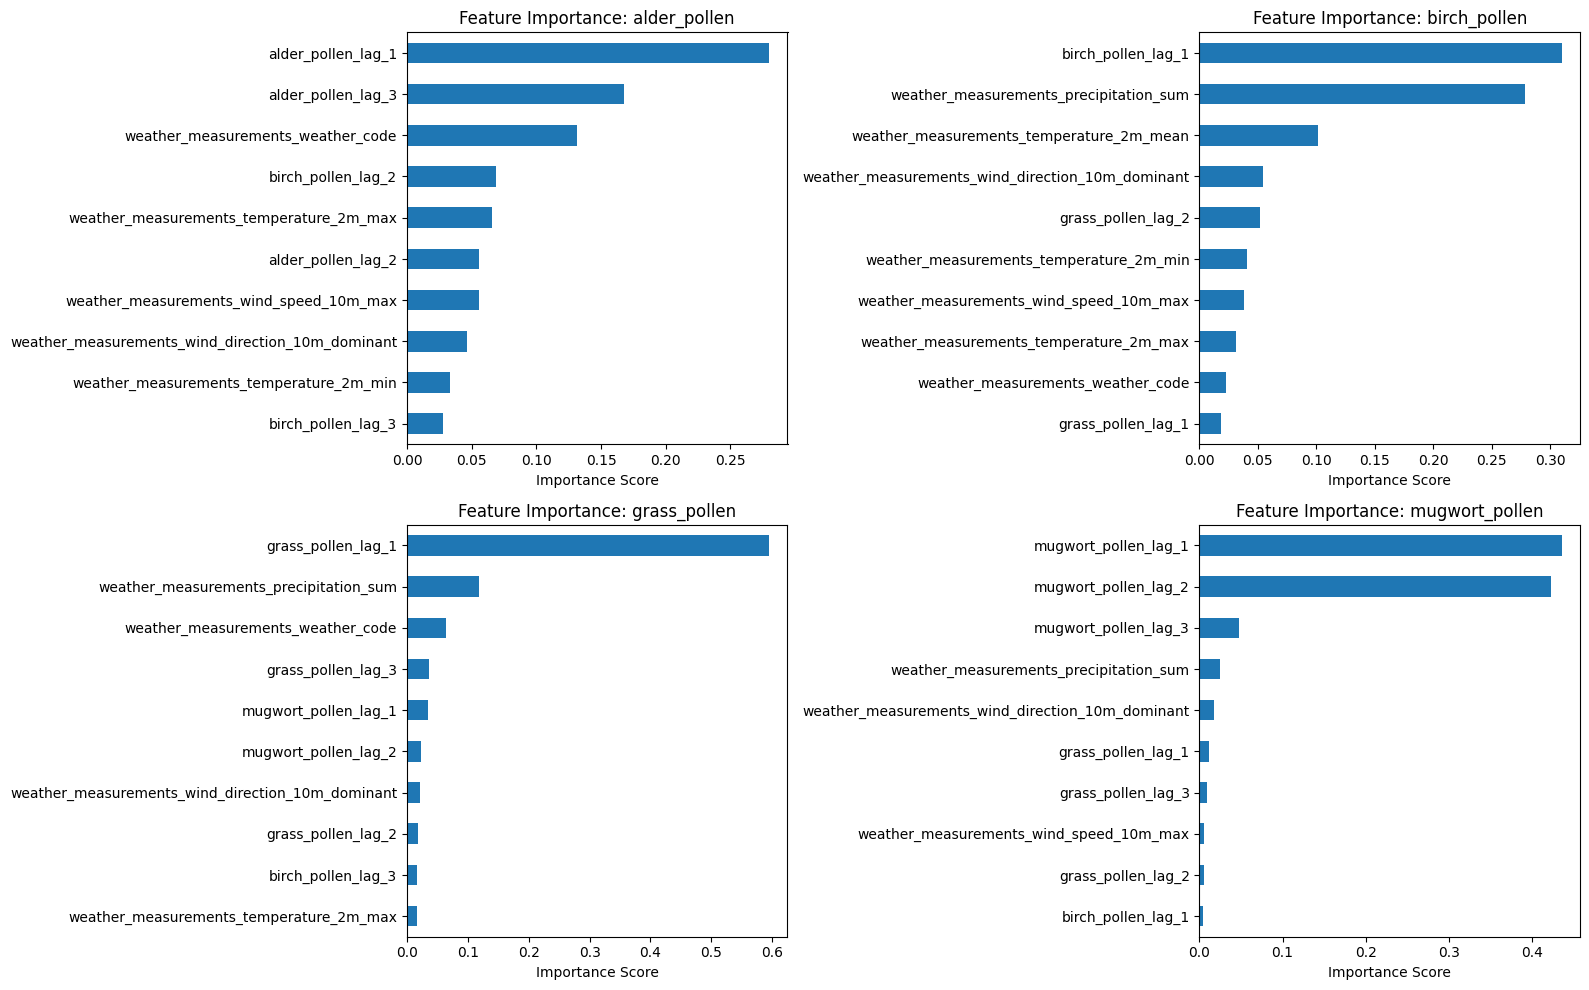

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Recuperiamo i nomi delle feature usate nel training
feature_names = train_cols

# Recuperiamo i nomi dei target (es. alder_pollen, birch_pollen...)
target_names = y_test.columns

# Creiamo un DataFrame per raccogliere le importanze
# model.estimators_ contiene la lista dei modelli XGBoost addestrati (uno per target)
importance_df = pd.DataFrame(index=feature_names)

for i, target in enumerate(target_names):
    # Estraiamo l'importanza delle feature per l'i-esimo modello
    importance = model.estimators_[i].feature_importances_
    importance_df[target] = importance

# Calcoliamo anche una media generale
importance_df['MEAN_IMPORTANCE'] = importance_df.mean(axis=1)

# Ordiniamo in base alla media
importance_df = importance_df.sort_values(by='MEAN_IMPORTANCE', ascending=False)

print("🔍 Top 10 Feature più importanti (Media generale):")
display(importance_df[['MEAN_IMPORTANCE']].head(10))

# --- Visualizzazione Grafica ---
# Plot delle top 10 feature per ogni polline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

for i, target in enumerate(target_names):
    # Ordiniamo le feature per questo specifico target
    top_features = importance_df[target].sort_values(ascending=False).head(10)
    
    # Bar plot
    top_features.plot(kind='barh', ax=axes[i], color='#1f77b4')
    axes[i].set_title(f"Feature Importance: {target}")
    axes[i].set_xlabel("Importance Score")
    axes[i].invert_yaxis() # Per avere la feature più importante in alto

plt.tight_layout()
plt.show()

## <span style='color:#ff5f27'>Model Registry</span>

In [13]:
import joblib
import os
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# 1. Connessione al Model Registry
mr = project.get_model_registry()

# 2. Definizione dello Schema
input_schema = Schema(X_train[train_cols])
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# 3. Preparazione Input Example
input_example = X_train[train_cols].sample(1)

# 4. Raccolta Metriche
metrics = {
    "mean_r2": np.mean(r2_scores),
    "mean_rmse": np.mean([np.sqrt(mean_squared_error(y_test[col], y_pred[:, i])) for i, col in enumerate(y_test.columns)])
}

# 5. Salvataggio del modello in locale (Step Fondamentale)
# Creiamo una cartella temporanea per gli artefatti del modello
model_dir = "pollen_model_artifacts"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Serializziamo il modello su disco usando joblib
joblib.dump(model, model_dir + "/pollen_xgboost_model.pkl")
print(f"Modello salvato localmente in: {model_dir}/pollen_xgboost_model.pkl")

# 6. Creazione dell'Oggetto Modello su Hopsworks
pollen_model = mr.python.create_model(
    name="pollen_stockholm_xgboost", 
    version=1,
    metrics=metrics,
    model_schema=model_schema,
    input_example=input_example, 
    description="Multi-Output XGBoost Regressor for Stockholm Pollen Prediction."
)

# 7. Upload su Hopsworks
# Passiamo il PERCORSO DELLA CARTELLA, non l'oggetto modello
print("💾 Upload del modello sul Model Registry...")
pollen_model.save(model_dir)

print("✅ Modello caricato correttamente!")
print(f"   Link: https://c.app.hopsworks.ai/p/{project.id}/models/{pollen_model.name}/{pollen_model.version}")

Modello salvato localmente in: pollen_model_artifacts/pollen_xgboost_model.pkl
💾 Upload del modello sul Model Registry...


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/woland02/VsCode/ID2223-ScalableMLDL_Project/notebooks/pollen_model_artifacts/pollen_xgboost_m…

Uploading /Users/woland02/VsCode/ID2223-ScalableMLDL_Project/notebooks/input_example.json: 0.000%|          | …

Uploading /Users/woland02/VsCode/ID2223-ScalableMLDL_Project/notebooks/model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1267872/models/pollen_stockholm_xgboost/1
✅ Modello caricato correttamente!
   Link: https://c.app.hopsworks.ai/p/1267872/models/pollen_stockholm_xgboost/1
